### Load spike times from Kilosort

In [ ]:
import h5py
import numpy as np

# --- Parameters ---
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'  # Update this
h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'  # from MATLAB export
#ei_positions = np.load('/path/to/ei_positions.npy')  # or load from .h5 if needed



sampling_rate = 20000  # Hz

# --- Load spike times from HDF5 ---
all_spikes = {}
with h5py.File(h5_in_path, 'r') as f:
    unit_ids = sorted(f['/spikes'].keys(), key=lambda x: int(x.split('_')[1]))
    for uid in unit_ids:
        unit_index = int(uid.split('_')[1])
        raw = f[f'/spikes/{uid}'][:]
        if raw.ndim == 1 and raw.shape[0] == 1:
            spikes_sec = np.array(raw[0]).flatten()
        else:
            spikes_sec = np.array(raw).flatten()
        spikes_samples = np.round(spikes_sec * sampling_rate).astype(np.int32)
        all_spikes[unit_index] = spikes_samples

    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]

params = {
    'window': (-20, 60),
    'min_spikes': 100,
    'ei_sim_threshold': 0.75,
    'k_start': 4,
    'k_refine': 2
}


### Select cell to clean up and run verification

In [103]:
from verify_cluster import verify_cluster

spike_times = all_spikes[565]
clusters = verify_cluster(
    spike_times=spike_times,
    dat_path=dat_path,
    params=params
)

print(f"Returned {len(clusters)} clean subclusters")
for i, cl in enumerate(clusters):
    print(f"  Cluster {i}: {len(cl['inds'])} spikes")


Returned 1 clean subclusters
  Cluster 0: 500 spikes


### Choose and evaluate cluster

In [93]:
# Merge [0,1,2,6] into one
inds_merge_1 = np.concatenate([clusters[i]['inds'] for i in [1,2]])

# Merge [3,4] into another
#inds_merge_2 = np.concatenate([clusters[i]['inds'] for i in [2,3]])

# Keep cluster[5] as-is
inds_keep = clusters[0]['inds']

# Final merged list of clusters (order doesn't matter here)
merged_clusters = [
    {'inds': inds_merge_1},
 #   {'inds': inds_merge_2},
    {'inds': inds_keep}
]


/home/alexth/python_code/Axolotl_v2/plot_ei_python.py:60: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(positions[i], radii[i], color=color, alpha=alpha, edgecolor='none')


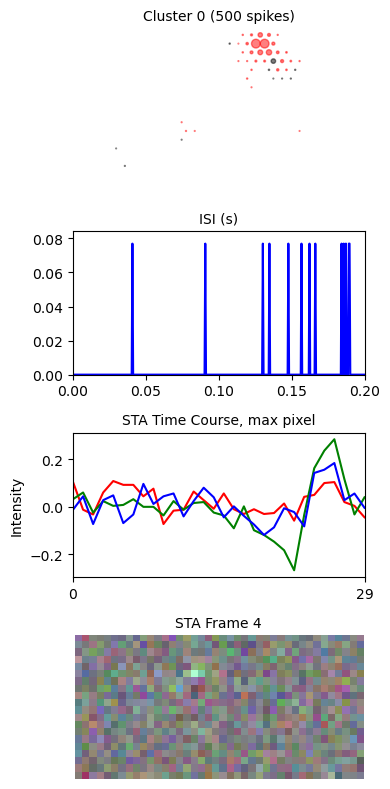

In [105]:

import analyze_clusters
import importlib
importlib.reload(analyze_clusters)


analyze_clusters.analyze_clusters(clusters,
                 spike_times=spike_times,
                 sampling_rate=20000,
                 dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat',
                 h5_path='/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5',
                 triggers_mat_path='/Volumes/Lab/Users/alexth/axolotl/trigger_in_samples_201703151.mat',
                 cluster_ids=None,
                 lut=None,
                 sta_depth=30,
                 sta_offset=0,
                 sta_chunk_size=1000,
                 sta_refresh=2,
                 ei_scale=3,
                 ei_cutoff=0.08)

In [13]:
inds = clusters[1]['inds']                      # indices into final_spike_times
spike_samples = spike_times[inds]         # sample indices
spikes_sec = spike_samples / sampling_rate

print(len(spikes_sec))

194


### calculate STA

In [14]:
from benchmark_c_rgb_generation import RGBFrameGenerator
from compute_sta_from_spikes import compute_sta_chunked
from scipy.io import loadmat


lut = np.array([
    [255, 255, 255],
    [255, 255,   0],
    [255,   0, 255],
    [255,   0,   0],
    [  0, 255, 255],
    [  0, 255,   0],
    [  0,   0, 255],
    [  0,   0,   0]
], dtype=np.uint8).flatten()

mat = loadmat('/Volumes/Lab/Users/alexth/axolotl/trigger_in_samples_201703151.mat')
triggers_sec = mat['triggers'].flatten()

generator = RGBFrameGenerator('/Volumes/Lab/Users/alexth/axolotl/sta/libdraw_rgb.so')
generator.configure(width=20, height=40, lut=lut, noise_type=1, n_bits=3)

sta = compute_sta_chunked(
    spikes_sec=spikes_sec,                 # your spike times (in samples)
    triggers_sec=triggers_sec,
    generator=generator,
    seed=11111,
    depth=20,
    offset=0,
    chunk_size=1000,
    refresh=2
)


### Plot STA

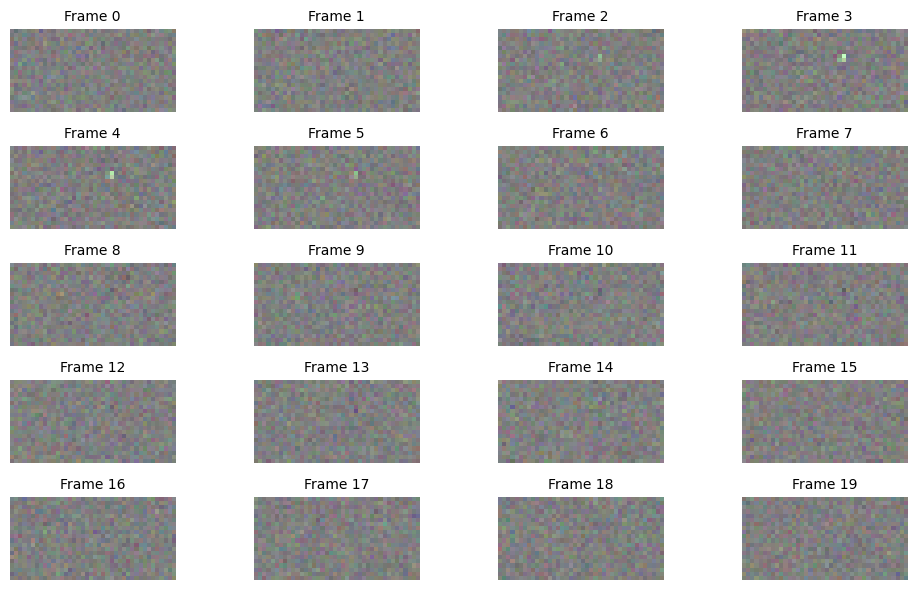

In [15]:
import matplotlib.pyplot as plt
import numpy as np


depth = sta.shape[3]
n_rows, n_cols = 5, 4
vmax = np.max(np.abs(sta)) * 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))
axes = axes.flatten()

for i in range(n_rows * n_cols):
    ax = axes[i]
    ax.axis('off')
    if i >= depth:
        continue
    rgb = sta[:, :, :, i]
    norm_rgb = (rgb) / (vmax)+0.5
    norm_rgb = np.clip(norm_rgb, 0, 1)
    ax.imshow(norm_rgb.transpose(1, 0, 2), origin='upper')
    ax.set_title(f'Frame {i}', fontsize=10)

plt.tight_layout()
plt.show()

### Compute EI

In [16]:
from extract_data_snippets import extract_snippets
from verify_cluster import compute_ei 

snips = extract_snippets(
    dat_path=dat_path,
    spike_times=spike_samples,
    window=(-20, 60),
    n_channels=512,
    dtype='int16'
)
ei = compute_ei(snips)

### Plot EI

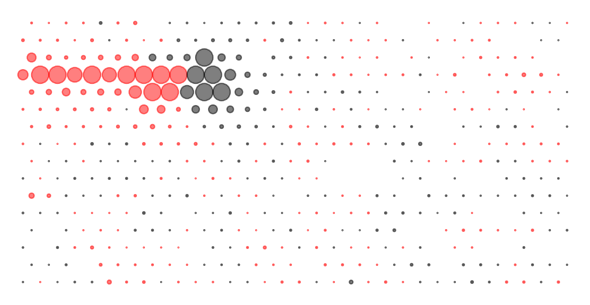

In [17]:
from plot_ei_python import plot_ei_python
import matplotlib.pyplot as plt


h5_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'

with h5py.File(h5_path, 'r') as f:
    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]

plt.figure(figsize=(6, 6))
    
plot_ei_python(ei, ei_positions, label=None, scale=3, cutoff=0.05, neg_color='red', pos_color='black', scale_ref_electrode=None)
num_spikes = len(spikes_sec)

plt.tight_layout()
plt.show()